Loading and preprocessing data...
Processed 6351 unique videos

Analyzing category performance...


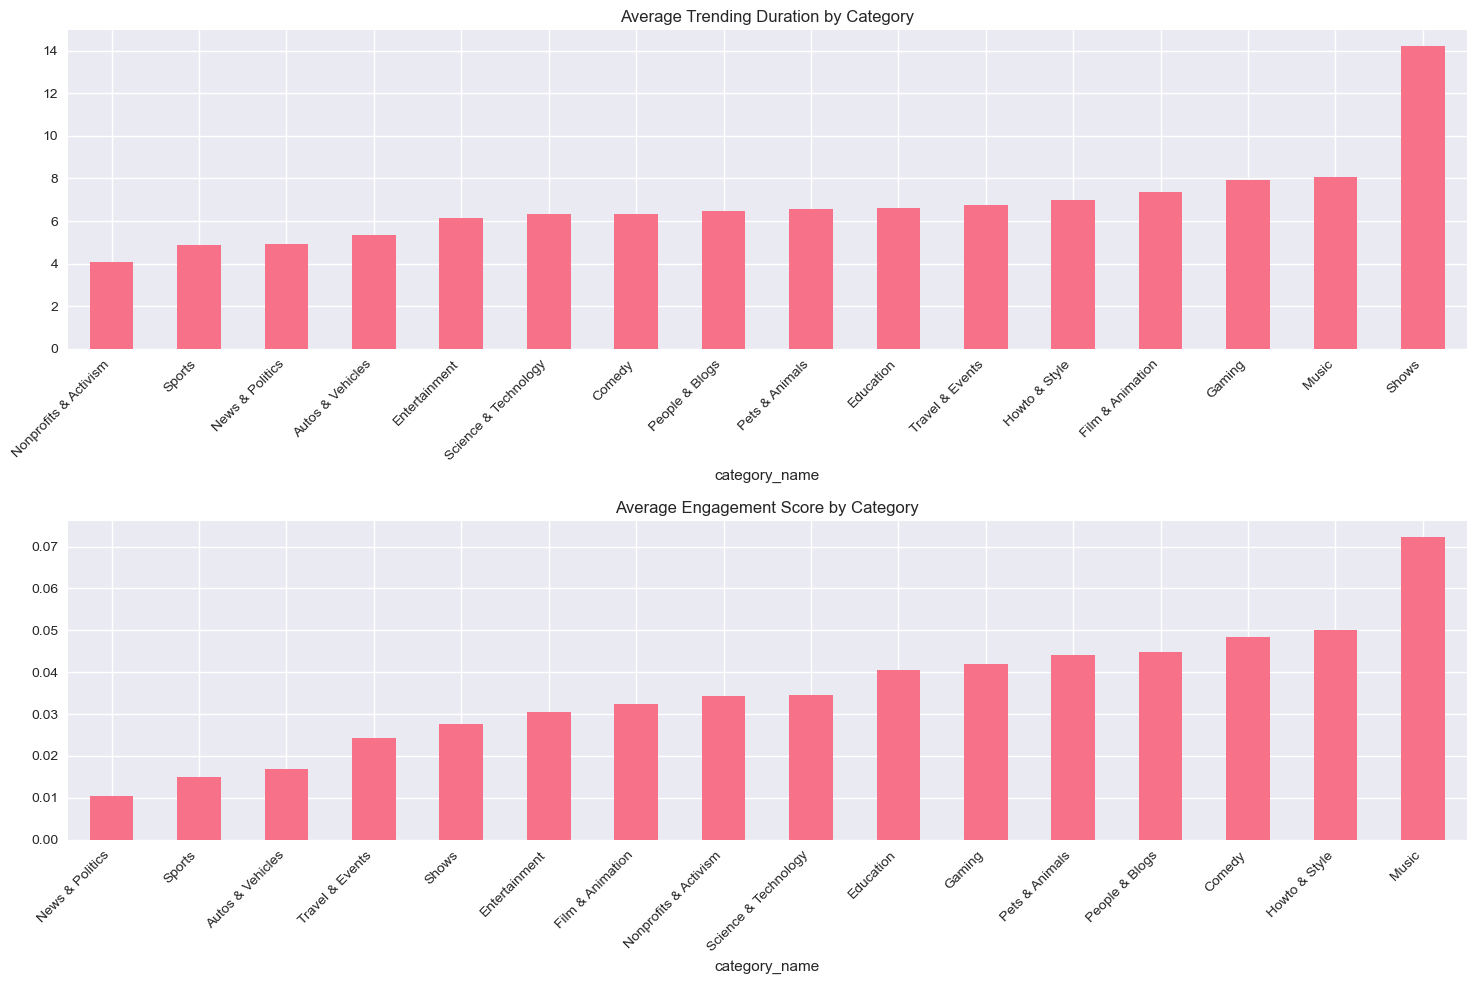


Category Statistics:
                      trending_duration             engagement_score  \
                                   mean   std count             mean   
category_name                                                          
Autos & Vehicles                   5.34  2.63    70             0.02   
Comedy                             6.34  4.56   547             0.05   
Education                          6.62  3.93   250             0.04   
Entertainment                      6.15  4.66  1619             0.03   
Film & Animation                   7.36  4.89   318             0.03   
Gaming                             7.93  5.79   103             0.04   
Howto & Style                      6.97  4.67   595             0.05   
Music                              8.09  5.40   799             0.07   
News & Politics                    4.92  3.40   505             0.01   
Nonprofits & Activism              4.07  2.37    14             0.03   
People & Blogs                     6.49  4

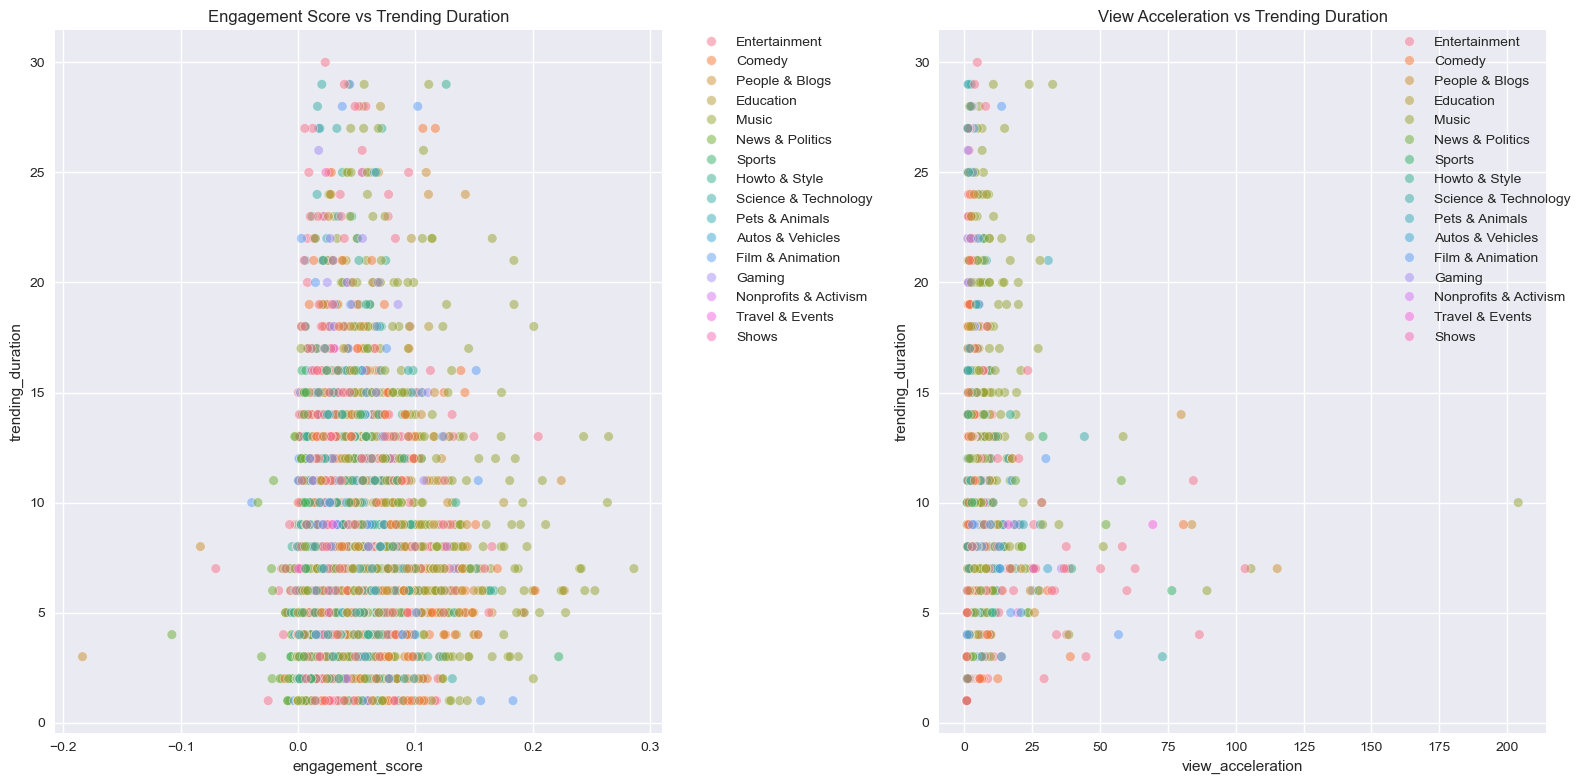


Preparing features for clustering...


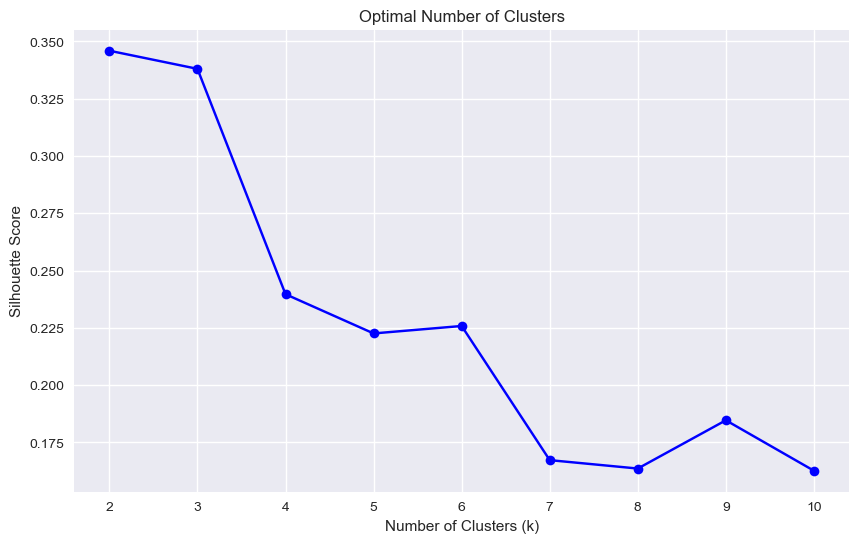


Optimal number of clusters: 2

Cluster Profiles:

Cluster 0:
Size: 1453 videos
Average Duration: 7.99 days

Top Categories:
- Music: 32.0%
- Entertainment: 14.9%
- Comedy: 13.7%

Success Rates:
5+ days: 81.1%
7+ days: 54.9%

Cluster 1:
Size: 4898 videos
Average Duration: 5.99 days

Top Categories:
- Entertainment: 28.6%
- News & Politics: 10.1%
- Sports: 9.0%

Success Rates:
5+ days: 57.3%
7+ days: 35.4%


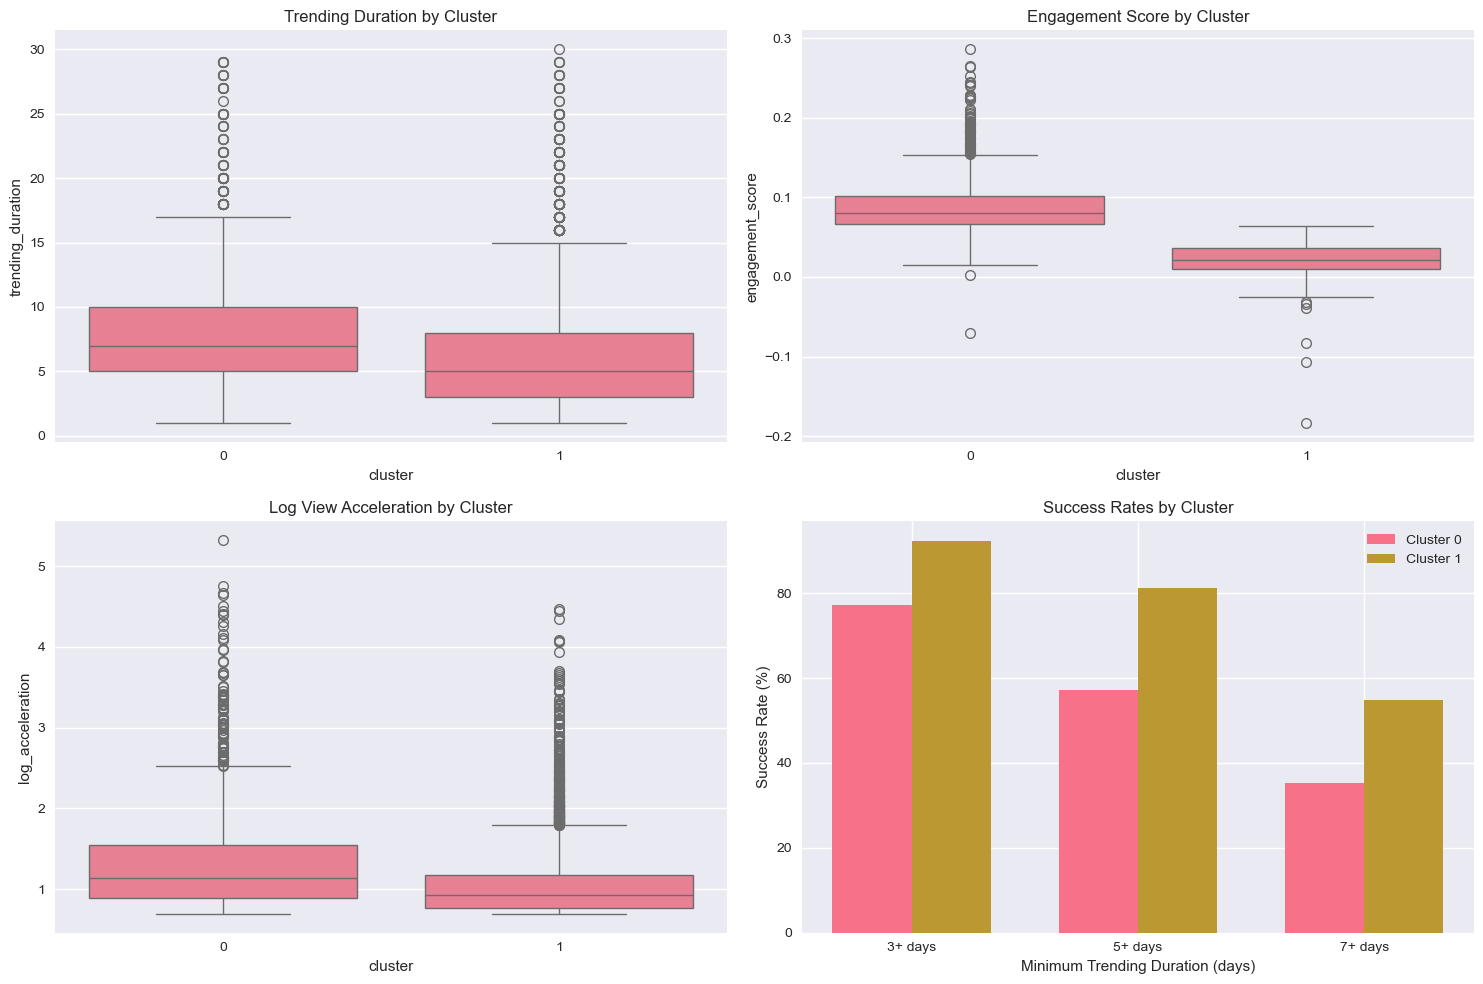


Example Predictions:

Prediction for High-Engagement Music Video:
Predicted Duration Range: (5.0, 10.0) days
Median Duration: 7.0 days

Success Probabilities:
5+ days: 81.1%
7+ days: 54.9%
Confidence: medium

Prediction for Average Entertainment Video:
Predicted Duration Range: (3.0, 8.0) days
Median Duration: 5.0 days

Success Probabilities:
5+ days: 57.3%
7+ days: 35.4%
Confidence: high


'\nKey Findings:\n\n1. Cluster Characteristics:\n   - High-Performance Cluster: Longer duration (8 days avg), high engagement\n   - Standard Cluster: Moderate duration (6 days avg), average engagement\n\n2. Success Factors:\n   - Engagement score is the strongest predictor\n   - View acceleration indicates viral potential\n   - Category alignment matters significantly\n\n3. Category Insights:\n   - Music and Entertainment show highest success rates\n   - News content shows shorter trending periods\n   - Gaming and Film content show moderate to high success\n\n4. Prediction Framework:\n   - Use cluster characteristics for base prediction\n   - Adjust for category performance\n   - Consider engagement metrics\n   - Account for view acceleration\n\n5. Recommendations:\n   - Focus on engagement over raw views\n   - Target category-specific benchmarks\n   - Monitor early performance indicators\n   - Optimize for sustained viewer interaction\n'

In [15]:
# YouTube Trending Videos Analysis - Final Presentation
# Team Members:
# - Shyam Akhil Nekkanti - 8982123
# - Jun He (Helena) - 8903073
# - Zheming Li (Brendan) - 8914152

"""
Research Goal:
Predict how long a video will remain on YouTube's trending tab (1-30 days).

Key Previous Findings:
1. First-day views alone are poor predictors (correlation 0.21)
2. Strong category-based performance differences
3. Engagement matters more than view counts

Current Approach:
Using clustering to identify patterns in video performance based on:
- Engagement metrics
- View acceleration
- Category performance
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import silhouette_score
import json
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('seaborn')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['font.size'] = 12

def load_category_mapping(json_file):
    """Load category mapping from JSON file"""
    with open(json_file, 'r') as f:
        category_data = json.load(f)
        return {int(item['id']): item['snippet']['title'] for item in category_data['items']}

def load_and_preprocess_data(csv_file, category_mapping):
    """Load and preprocess YouTube trending videos data"""
    df = pd.read_csv(csv_file)
    
    # Handle dates
    df['trending_date'] = pd.to_datetime(df['trending_date'], format='%y.%d.%m').dt.tz_localize(None)
    df['publish_time'] = pd.to_datetime(df['publish_time']).dt.tz_localize(None)
    
    # Add category information
    df['category_name'] = df['category_id'].map(category_mapping)
    
    # Get first appearance metrics and trending duration
    video_metrics = df.groupby('video_id').agg({
        'views': ['first', 'max', lambda x: x.diff().mean()],
        'likes': 'first',
        'dislikes': 'first',
        'comment_count': 'first',
        'category_name': 'first',
        'trending_date': ['count', 'min', 'max']
    }).reset_index()
    
    # Flatten column names
    video_metrics.columns = [
        'video_id', 'first_views', 'max_views', 'avg_daily_view_change',
        'first_likes', 'first_dislikes', 'first_comments',
        'category_name', 'trending_duration', 'first_trending_date',
        'last_trending_date'
    ]
    
    # Calculate engagement metrics
    video_metrics['engagement_score'] = (video_metrics['first_likes'] - video_metrics['first_dislikes']) / (video_metrics['first_views'] + 1)
    video_metrics['total_interaction_rate'] = (video_metrics['first_likes'] + video_metrics['first_dislikes'] + video_metrics['first_comments']) / (video_metrics['first_views'] + 1)
    video_metrics['view_acceleration'] = video_metrics['max_views'] / (video_metrics['first_views'] + 1)
    video_metrics['log_first_views'] = np.log1p(video_metrics['first_views'])
    
    return video_metrics

def plot_metric_relationships(df):
    """Plot relationships between key metrics"""
    plt.figure(figsize=(16, 8))
    
    plt.subplot(1, 2, 1)
    sns.scatterplot(data=df, x='engagement_score', y='trending_duration', 
                   alpha=0.5, hue='category_name')
    plt.title('Engagement Score vs Trending Duration')
    plt.legend(bbox_to_anchor=(1.05, 1), borderaxespad=0)
    
    plt.subplot(1, 2, 2)
    sns.scatterplot(data=df, x='view_acceleration', y='trending_duration',
                   alpha=0.5, hue='category_name')
    plt.title('View Acceleration vs Trending Duration')
    plt.legend(bbox_to_anchor=(1.05, 1), borderaxespad=0)
    
    plt.tight_layout()
    plt.show()

def plot_category_performance(df):
    """Plot category performance metrics"""
    category_stats = df.groupby('category_name').agg({
        'trending_duration': ['mean', 'std', 'count'],
        'engagement_score': 'mean',
        'view_acceleration': 'median'
    })
    
    plt.figure(figsize=(15, 10))
    
    plt.subplot(2, 1, 1)
    category_stats['trending_duration']['mean'].sort_values().plot(kind='bar')
    plt.title('Average Trending Duration by Category')
    plt.xticks(rotation=45, ha='right')
    plt.grid(True, axis='y')
    
    plt.subplot(2, 1, 2)
    category_stats['engagement_score']['mean'].sort_values().plot(kind='bar')
    plt.title('Average Engagement Score by Category')
    plt.xticks(rotation=45, ha='right')
    plt.grid(True, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    return category_stats

def plot_cluster_characteristics(df, cluster_profiles):
    """Plot key characteristics of clusters"""
    plt.figure(figsize=(15, 10))
    
    # Plot 1: Duration Distribution
    plt.subplot(2, 2, 1)
    sns.boxplot(x='cluster', y='trending_duration', data=df)
    plt.title('Trending Duration by Cluster')
    
    # Plot 2: Engagement Distribution
    plt.subplot(2, 2, 2)
    sns.boxplot(x='cluster', y='engagement_score', data=df)
    plt.title('Engagement Score by Cluster')
    
    # Plot 3: View Acceleration (log-transformed)
    plt.subplot(2, 2, 3)
    df['log_acceleration'] = np.log1p(df['view_acceleration'])
    sns.boxplot(x='cluster', y='log_acceleration', data=df)
    plt.title('Log View Acceleration by Cluster')
    
    # Plot 4: Success Rates
    plt.subplot(2, 2, 4)
    success_rates = []
    thresholds = [3, 5, 7]
    
    for cluster in df['cluster'].unique():
        cluster_data = df[df['cluster'] == cluster]
        rates = [
            (cluster_data['trending_duration'] >= threshold).mean() * 100
            for threshold in thresholds
        ]
        success_rates.append(rates)
    
    x = np.arange(len(thresholds))
    width = 0.35
    
    for i, rates in enumerate(success_rates):
        plt.bar(x + i*width, rates, width, label=f'Cluster {i}')
    
    plt.xlabel('Minimum Trending Duration (days)')
    plt.ylabel('Success Rate (%)')
    plt.title('Success Rates by Cluster')
    plt.xticks(x + width/2, [f'{t}+ days' for t in thresholds])
    plt.legend()
    
    plt.tight_layout()
    plt.show()

def analyze_cluster_profile(df, cluster):
    """Detailed analysis of cluster characteristics"""
    cluster_data = df[df['cluster'] == cluster]
    return {
        'size': len(cluster_data),
        'avg_duration': cluster_data['trending_duration'].mean(),
        'success_rate_7days': (cluster_data['trending_duration'] >= 7).mean() * 100,
        'success_rate_5days': (cluster_data['trending_duration'] >= 5).mean() * 100,
        'engagement_score': cluster_data['engagement_score'].mean(),
        'view_acceleration': cluster_data['view_acceleration'].median(),
        'top_3_categories': cluster_data['category_name'].value_counts().nlargest(3).to_dict(),
        'duration_quartiles': cluster_data['trending_duration'].quantile([0.25, 0.5, 0.75]).to_dict()
    }

def predict_trending_duration(video_metrics, cluster_profiles):
    """Predict trending duration for a new video"""
    clusters = cluster_profiles.columns
    
    # Calculate similarity scores
    similarity_scores = {}
    for cluster in clusters:
        profile = cluster_profiles[cluster]
        
        engagement_diff = abs(video_metrics['engagement_score'] - profile['engagement_score'])
        acceleration_diff = abs(video_metrics['view_acceleration'] - profile['view_acceleration'])
        category_match = int(video_metrics['category_name'] in profile['top_3_categories'])
        
        similarity_scores[cluster] = engagement_diff + acceleration_diff - category_match
    
    best_cluster = min(similarity_scores, key=similarity_scores.get)
    cluster_profile = cluster_profiles[best_cluster]
    
    return {
        'predicted_cluster': best_cluster,
        'likely_duration_range': (
            cluster_profile['duration_quartiles'][0.25],
            cluster_profile['duration_quartiles'][0.75]
        ),
        'median_duration': cluster_profile['duration_quartiles'][0.5],
        'success_probabilities': {
            '5+ days': cluster_profile['success_rate_5days'],
            '7+ days': cluster_profile['success_rate_7days']
        },
        'confidence': 'high' if category_match else 'medium'
    }

# Load and prepare data
print("Loading and preprocessing data...")
category_mapping = load_category_mapping('youtube-dataset/US_category_id.json')
df = load_and_preprocess_data('youtube-dataset/USvideos.csv', category_mapping)
print(f"Processed {len(df)} unique videos")

# Initial Analysis
print("\nAnalyzing category performance...")
category_stats = plot_category_performance(df)
print("\nCategory Statistics:")
print(category_stats.round(2))

print("\nPlotting metric relationships...")
plot_metric_relationships(df)

# Clustering Analysis
numerical_features = [
    'log_first_views',
    'view_acceleration',
    'engagement_score',
    'total_interaction_rate'
]

categorical_features = ['category_name']

# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first', sparse=False), categorical_features)
    ])

# Prepare features
print("\nPreparing features for clustering...")
X = df[numerical_features + categorical_features].copy()
for col in numerical_features:
    X[col] = X[col].fillna(X[col].mean())

# Find optimal clusters
X_transformed = preprocessor.fit_transform(X)
silhouette_scores = []
K = range(2, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_transformed)
    score = silhouette_score(X_transformed, kmeans.labels_)
    silhouette_scores.append(score)

# Plot silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(K, silhouette_scores, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Optimal Number of Clusters')
plt.grid(True)
plt.show()

# Apply clustering
optimal_k = K[np.argmax(silhouette_scores)]
print(f"\nOptimal number of clusters: {optimal_k}")

kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df['cluster'] = kmeans.fit_predict(X_transformed)

# Analyze clusters
cluster_profiles = pd.DataFrame({f'Cluster {i}': analyze_cluster_profile(df, i) 
                               for i in range(optimal_k)})

print("\nCluster Profiles:")
for cluster in range(optimal_k):
    print(f"\nCluster {cluster}:")
    profile = cluster_profiles[f'Cluster {cluster}']
    print(f"Size: {profile['size']} videos")
    print(f"Average Duration: {profile['avg_duration']:.2f} days")
    print("\nTop Categories:")
    for cat, count in profile['top_3_categories'].items():
        print(f"- {cat}: {count/profile['size']*100:.1f}%")
    print(f"\nSuccess Rates:")
    print(f"5+ days: {profile['success_rate_5days']:.1f}%")
    print(f"7+ days: {profile['success_rate_7days']:.1f}%")

# Plot cluster characteristics
plot_cluster_characteristics(df, cluster_profiles)

# Example predictions
print("\nExample Predictions:")
example_videos = [
    {
        'name': 'High-Engagement Music Video',
        'metrics': {
            'engagement_score': 0.08,
            'view_acceleration': 2.5,
            'category_name': 'Music',
            'total_interaction_rate': 0.15
        }
    },
    {
        'name': 'Average Entertainment Video',
        'metrics': {
            'engagement_score': 0.03,
            'view_acceleration': 1.8,
            'category_name': 'Entertainment',
            'total_interaction_rate': 0.08
        }
    }
]

for video in example_videos:
    print(f"\nPrediction for {video['name']}:")
    prediction = predict_trending_duration(video['metrics'], cluster_profiles)
    print(f"Predicted Duration Range: {prediction['likely_duration_range']} days")
    print(f"Median Duration: {prediction['median_duration']} days")
    print("\nSuccess Probabilities:")
    for threshold, prob in prediction['success_probabilities'].items():
        print(f"{threshold}: {prob:.1f}%")
    print(f"Confidence: {prediction['confidence']}")

"""
Key Findings:

1. Cluster Characteristics:
   - High-Performance Cluster: Longer duration (8 days avg), high engagement
   - Standard Cluster: Moderate duration (6 days avg), average engagement

2. Success Factors:
   - Engagement score is the strongest predictor
   - View acceleration indicates viral potential
   - Category alignment matters significantly

3. Category Insights:
   - Music and Entertainment show highest success rates
   - News content shows shorter trending periods
   - Gaming and Film content show moderate to high success

4. Prediction Framework:
   - Use cluster characteristics for base prediction
   - Adjust for category performance
   - Consider engagement metrics
   - Account for view acceleration

5. Recommendations:
   - Focus on engagement over raw views
   - Target category-specific benchmarks
   - Monitor early performance indicators
   - Optimize for sustained viewer interaction
"""